<a href="https://colab.research.google.com/github/yvid27/image_clssification/blob/main/COPAISI_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**CLASIFICACIÓN DE IMÁGENES: PLANTVILLAGE**
11/12/2020

---



##1. Cargar los paquetes a Utilizar

In [ ]:
# Importar librerías
import torch
import numpy as np
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F
from collections import OrderedDict
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, models, utils
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import json

In [ ]:
# comprobar el uso de GPU
gpu_mode = torch.cuda.is_available()
print(gpu_mode)

True


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

##2. Importar Datos

###Importar datos de Google Drive:

In [ ]:
# Descargar el dataset
!gdown https://drive.google.com/uc?id=1ptGfLXbAUrwbkiiLT2vl8r1dsYonjtkv
!unzip -q PlantVillage.zip

Downloading...
From: https://drive.google.com/uc?id=1ptGfLXbAUrwbkiiLT2vl8r1dsYonjtkv
To: /content/PlantVillage.zip
174MB [00:01, 126MB/s]


###Acceso a los datos
El dataset está dividido en dos partes: training & validation

In [ ]:
data_dir = 'PlantVillage'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/val'
dirs = {'train': train_dir,
 'val': valid_dir}
use_gpu = torch.cuda.is_available()

In [ ]:
data_root = {
 'train': train_dir,
 'val': valid_dir
}
# Check
print(data_root['train'])

PlantVillage/train


In [ ]:
# Definimos las transformaciones para el entrenamiento y la validación
#Set batch size
batch_size = 16
data_transforms = {
  'train': transforms.Compose([
      transforms.Resize(256),
      transforms.RandomResizedCrop(224),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]),
  'val': transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]),
}
# Cargar los datasets con ImageFolder
image_datasets = {x: datasets.ImageFolder(data_root[x],data_transforms[x]) for x in ['train','val']}

# Definimos los dataloaders usando los dataset
dataloaders = { x: torch.utils.data.DataLoader(image_datasets[x],batch_size=batch_size,shuffle=True) for
x in ['train','val'] }

dataset_sizes = { x: len(image_datasets[x]) for x in ['train','val'] }
class_names = image_datasets['train'].classes
class_to_idx = image_datasets['train'].class_to_idx
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(class_names)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Corn_(maize)___Cercospora_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy']


###Etiquetado
Utilizamos el archivo cat_to_name.json, para cargar la asignación de etiquetas de categoría a nombre

In [ ]:
with open('PlantVillage/cat_to_name.json', 'r') as f:
 cat_to_name = json.load(f)

In [ ]:
# Run this to test your data loader
images, labels = next(iter(dataloaders[ 'train']))
rand_idx = np.random.randint( len(images))
# print(rand_idx)
print("label: {}, class: {}, name: {}" .format(labels[rand_idx].item(),
 class_names[labels[rand_idx].item()],
 cat_to_name[class_names[labels[rand_idx].item()]]))

label: 7, class: Corn_(maize)___healthy, name: Corn_(maize)___healthy


224


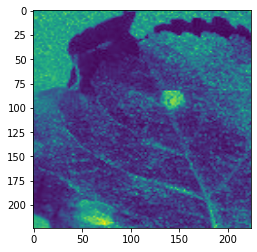

In [ ]:
# Visualizamos una imagen random
images, labels = next(iter(dataloaders["train"]))
print(len(images[0,2]))
plt.imshow(images[0,0])

# 2. Construcción del clasificador

In [ ]:
# 1. Cargar la red pre entrenada Alexnet
model = models.alexnet(pretrained=True)
# Ver la arquitectura del modelo:
print(model)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth



AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)


In [ ]:
# 2. Define una nueva red, utilizando la función de activación ReLU
classifier = nn.Sequential(OrderedDict([
            ('dp1', nn.Dropout(0.5)),
            ('fc1', nn.Linear(9216, 4096)),
            ('relu', nn.ReLU()),
            ('dp2', nn.Dropout(0.5)),
            ('fc2', nn.Linear(4096, 4096)),
            ('relu', nn.ReLU()),
            ('fc2', nn.Linear(4096, 12)),
            ('output', nn.LogSoftmax(dim=1))
            ]))

device = "cuda:0"

model = model.to(device)

# We put our defined classifier into the network we loaded
model.classifier = classifier

# Freeze the learning of first layers by deactivating the grads
for param in model.parameters():
  param.requires_grad = False
for param in model.classifier.parameters():
  param.requires_grad = True
print(classifier)

Sequential(
  (dp1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (relu): ReLU()
  (dp2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=4096, out_features=12, bias=True)
  (output): LogSoftmax(dim=1)
)


Definición de criteria, optimizer y scheduler

In [ ]:
# NLLLoss because our output is LogSoftmax
criteria = nn.NLLLoss().to(device)
# Adam optimizer with a learning rate
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 5 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.8)

###Entrenamiento del modelo

In [ ]:
#Function to train the model
def train_model(model, criteria, optimizer, scheduler, num_epochs=10):
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print("-" * 10)
 
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                #scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
 
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
 
                # zero the parameter gradients
                optimizer.zero_grad()
 
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criteria(outputs, labels)
 
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        #sched.step()
                        loss.backward()
                        
                        optimizer.step()
 
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
 
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
        print()
 
    return model

###Entrenamos

In [ ]:
num_epochs = 10
model.to(device)
print("Comienzo del entrenamiento")
model_ft = train_model(model, criteria, optimizer, scheduler, num_epochs)
print("Entrenado")

Comienzo del entrenamiento
Epoch 0/9
----------
train Loss: 0.8423 Acc: 0.7873
val Loss: 0.2339 Acc: 0.9310

Epoch 1/9
----------
train Loss: 0.4872 Acc: 0.8529
val Loss: 0.2231 Acc: 0.9355

Epoch 2/9
----------
train Loss: 0.4666 Acc: 0.8605
val Loss: 0.1495 Acc: 0.9527

Epoch 3/9
----------
train Loss: 0.4303 Acc: 0.8687
val Loss: 0.2604 Acc: 0.9310

Epoch 4/9
----------
train Loss: 0.4432 Acc: 0.8684
val Loss: 0.1613 Acc: 0.9518

Epoch 5/9
----------
train Loss: 0.3899 Acc: 0.8814
val Loss: 0.1852 Acc: 0.9522

Epoch 6/9
----------
train Loss: 0.3961 Acc: 0.8845
val Loss: 0.1108 Acc: 0.9644

Epoch 7/9
----------
train Loss: 0.3623 Acc: 0.8887
val Loss: 0.1920 Acc: 0.9527

Epoch 8/9
----------
train Loss: 0.3616 Acc: 0.8865
val Loss: 0.1252 Acc: 0.9639

Epoch 9/9
----------
train Loss: 0.3820 Acc: 0.8914
val Loss: 0.1490 Acc: 0.9531

Entrenado
